In [1]:
import pandas as pd
import os
all_files = os.listdir('Data')
xlsx_files = [file for file in all_files if file.endswith('.xlsx')]
print("Excel Files:", xlsx_files)

dfs = []
for file in xlsx_files:
    file_path = os.path.join('Data', file)
    if os.path.exists(file_path):
        df = pd.read_excel(file_path)
        dfs.append(df)
    else:
        print(f"File not found: {file_path}")
df_df = pd.concat(dfs, ignore_index=True)

Excel Files: ['dataset_Google-Maps-Reviews-Scraper_2023-10-07_05-38-02-353.xlsx', 'dataset_Google-Maps-Reviews-Scraper_2023-10-07_20-39-19-861.xlsx', 'dataset_Google-Maps-Reviews-Scraper_2023-10-07_21-20-35-389.xlsx', 'dataset_Google-Maps-Reviews-Scraper_2023-10-07_21-52-25-741.xlsx', 'dataset_Google-Maps-Reviews-Scraper_2023-10-07_22-26-46-127.xlsx']


In [2]:
df_df.head()

,title,categoryName,website,url,reviewsCount,stars,text
0,The Optimist,Seafood restaurant,https://www.theoptimistrestaurant.com/,https://www.google.com/maps/place/The+Optimist...,3349,4.0,NaN
1,The Optimist,Seafood restaurant,https://www.theoptimistrestaurant.com/,https://www.google.com/maps/place/The+Optimist...,3349,5.0,NaN
2,The Optimist,Seafood restaurant,https://www.theoptimistrestaurant.com/,https://www.google.com/maps/place/The+Optimist...,3349,5.0,"One word amazing!! The red fish, halibut, fr..."
3,The Optimist,Seafood restaurant,https://www.theoptimistrestaurant.com/,https://www.google.com/maps/place/The+Optimist...,3349,5.0,First time here and the food is great and the ...
4,The Optimist,Seafood restaurant,https://www.theoptimistrestaurant.com/,https://www.google.com/maps/place/The+Optimist...,3349,5.0,I recently had the pleasure of dining at Optim...


In [3]:
import re
pattern = r'@(-?\d+\.\d+),(-?\d+\.\d+)'

df_df[['latitude', 'longitude']] = df_df['url'].str.extract(pattern)
df_df['latitude'] = pd.to_numeric(df_df['latitude'])
df_df['longitude'] = pd.to_numeric(df_df['longitude'])
print(df_df.loc[:, ['url', 'longitude', 'latitude']])

                                                      url  longitude  \
0       https://www.google.com/maps/place/The+Optimist... -84.410451   
1       https://www.google.com/maps/place/The+Optimist... -84.410451   
2       https://www.google.com/maps/place/The+Optimist... -84.410451   
3       https://www.google.com/maps/place/The+Optimist... -84.410451   
4       https://www.google.com/maps/place/The+Optimist... -84.410451   
...                                                   ...        ...   
127225  https://www.google.com/maps/place/WNB+Factory+... -84.533105   
127226  https://www.google.com/maps/place/WNB+Factory+... -84.533105   
127227  https://www.google.com/maps/place/WNB+Factory+... -84.533105   
127228  https://www.google.com/maps/place/WNB+Factory+... -84.533105   
127229  https://www.google.com/maps/place/WNB+Factory+... -84.533105   

         latitude  
0       33.779814  
1       33.779814  
2       33.779814  
3       33.779814  
4       33.779814  
...           .

In [4]:
df = df_df.dropna(subset=['text'])

In [5]:
df.head()

,title,categoryName,website,url,reviewsCount,stars,text,latitude,longitude
2,The Optimist,Seafood restaurant,https://www.theoptimistrestaurant.com/,https://www.google.com/maps/place/The+Optimist...,3349,5.0,"One word amazing!! The red fish, halibut, fr...",33.779814,-84.410451
3,The Optimist,Seafood restaurant,https://www.theoptimistrestaurant.com/,https://www.google.com/maps/place/The+Optimist...,3349,5.0,First time here and the food is great and the ...,33.779814,-84.410451
4,The Optimist,Seafood restaurant,https://www.theoptimistrestaurant.com/,https://www.google.com/maps/place/The+Optimist...,3349,5.0,I recently had the pleasure of dining at Optim...,33.779814,-84.410451
5,The Optimist,Seafood restaurant,https://www.theoptimistrestaurant.com/,https://www.google.com/maps/place/The+Optimist...,3349,5.0,Beautiful atmosphere and delicious food. All o...,33.779814,-84.410451
6,The Optimist,Seafood restaurant,https://www.theoptimistrestaurant.com/,https://www.google.com/maps/place/The+Optimist...,3349,5.0,We had a wonderful dinner at the Optimist. Our...,33.779814,-84.410451


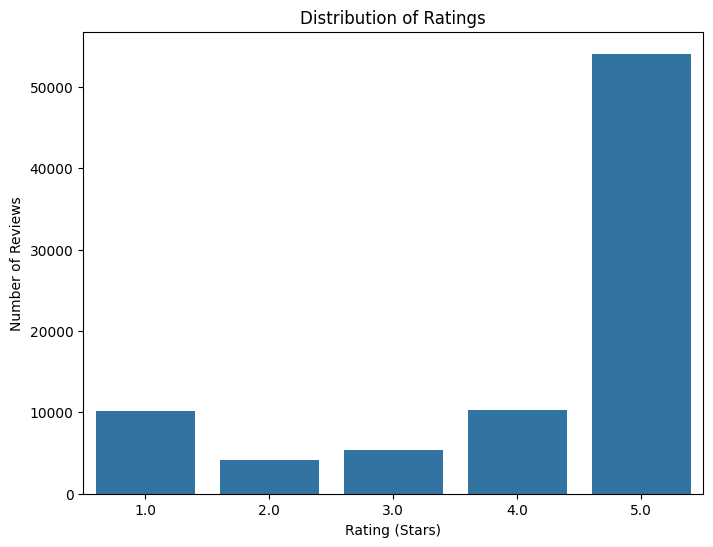

In [6]:

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='stars')
plt.title('Distribution of Ratings')
plt.ylabel('Number of Reviews')
plt.xlabel('Rating (Stars)')
plt.show()


In [7]:
from sklearn.utils import resample

positive_reviews = df[df['stars'] >= 4]
negative_reviews = df[df['stars'] <= 2]

df = df[df['stars'] != 3]

negative_reviews_upsampled = resample(negative_reviews,
                                      replace=True,
                                      n_samples=len(positive_reviews),
                                      random_state=42)

data = pd.concat([positive_reviews, negative_reviews_upsampled])

balanced_distribution = data['stars'].value_counts()
balanced_distribution


stars
5.0    54066
1.0    45754
2.0    18648
4.0    10336
Name: count, dtype: int64

In [8]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string

# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    text = ' '.join(words)
    return text

data['_text'] = data['text'].apply(preprocess_text)

data[['text', '_text']].head()


,text,_text
2,"One word amazing!! The red fish, halibut, fr...",one word amazing red fish halibut fried rice b...
3,First time here and the food is great and the ...,first time food great waiter excellent
4,I recently had the pleasure of dining at Optim...,recently pleasure dining optimist atlanta ga l...
5,Beautiful atmosphere and delicious food. All o...,beautiful atmosphere delicious food food ’ fla...
6,We had a wonderful dinner at the Optimist. Our...,wonderful dinner optimist group 9 great meal o...


In [9]:
data2 = data.copy()

In [10]:
import pandas as pd
from transformers import pipeline

sentiment_pipeline = pipeline("sentiment-analysis")

def get_sentiment_score(review):
    result = sentiment_pipeline(review)
    sentiment = result[0]['label']
    score = result[0]['score']
    return sentiment, score

data['sentiment_score'] = data['_text'].apply(lambda x: get_sentiment_score(x))

data.head()


c:\Users\rohit\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
config.json: 100%|██████████| 629/629 [00:00<?, ?B/s] 
c:\Users\rohit\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\rohit\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or t

In [18]:
def stars_to_sentiment(stars):
    if stars >= 4:
        return 'POSITIVE'
    elif stars <= 2:
        return 'NEGATIVE'
    else:
        return 'NEUTRAL'

data['true_label'] = data['stars'].apply(stars_to_sentiment)

In [16]:
from transformers import pipeline
from nltk.tokenize import sent_tokenize

sentiment_pipeline = pipeline("sentiment-analysis")

def analyze_aspect_sentiments(text, aspects):
    sentences = sent_tokenize(text)
    aspect_sentiments = {aspect: [] for aspect in aspects}

    for sentence in sentences:
        mentioned_aspects = [aspect for aspect in aspects if aspect in sentence]
        if mentioned_aspects:
            result = sentiment_pipeline(sentence)
            sentiment = result[0]['label']
            for aspect in mentioned_aspects:
                aspect_sentiments[aspect].append(sentiment)

    aggregated_sentiments = {}
    for aspect, sentiments in aspect_sentiments.items():
        if sentiments:
            aggregated_sentiments[aspect] = max(set(sentiments), key=sentiments.count)
        else:
            aggregated_sentiments[aspect] = None

    return aggregated_sentiments


aspects = ["food", "service", "ambiance", "staff", "price", "location", "menu"]

aspect_sentiment_columns = data2['text'].apply(lambda x: analyze_aspect_sentiments(x, aspects))

aspect_sentiment_df = aspect_sentiment_columns.apply(pd.Series)

data2 = data2.join(aspect_sentiment_df)

print(data2)


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


C:\Users\rohit\AppData\Local\Temp\ipykernel_5608\1385427595.py:35: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  aspect_sentiment_df = aspect_sentiment_columns.apply(pd.Series)


                               title        categoryName  \
2                       The Optimist  Seafood restaurant   
3                       The Optimist  Seafood restaurant   
4                       The Optimist  Seafood restaurant   
5                       The Optimist  Seafood restaurant   
6                       The Optimist  Seafood restaurant   
...                              ...                 ...   
127220  WNB Factory - Wings & Burger          Restaurant   
127222  WNB Factory - Wings & Burger          Restaurant   
127224  WNB Factory - Wings & Burger          Restaurant   
127225  WNB Factory - Wings & Burger          Restaurant   
127228  WNB Factory - Wings & Burger          Restaurant   

                                       website  \
2       https://www.theoptimistrestaurant.com/   
3       https://www.theoptimistrestaurant.com/   
4       https://www.theoptimistrestaurant.com/   
5       https://www.theoptimistrestaurant.com/   
6       https://www.theoptimi

In [17]:
data2.head()

,title,categoryName,website,url,reviewsCount,stars,text,latitude,longitude,_text,sentiment_score,food,service,ambiance,staff,price,location,menu
2,The Optimist,Seafood restaurant,https://www.theoptimistrestaurant.com/,https://www.google.com/maps/place/The+Optimist...,3349,5.0,"One word amazing!! The red fish, halibut, fr...",33.779814,-84.410451,one word amazing red fish halibut fried rice b...,"(POSITIVE, 0.9867098927497864)",None,None,None,None,None,None,None
3,The Optimist,Seafood restaurant,https://www.theoptimistrestaurant.com/,https://www.google.com/maps/place/The+Optimist...,3349,5.0,First time here and the food is great and the ...,33.779814,-84.410451,first time food great waiter excellent,"(POSITIVE, 0.9997603297233582)",POSITIVE,None,None,None,None,None,None
4,The Optimist,Seafood restaurant,https://www.theoptimistrestaurant.com/,https://www.google.com/maps/place/The+Optimist...,3349,5.0,I recently had the pleasure of dining at Optim...,33.779814,-84.410451,recently pleasure dining optimist atlanta ga l...,"(POSITIVE, 0.9986514449119568)",POSITIVE,POSITIVE,POSITIVE,None,None,None,POSITIVE
5,The Optimist,Seafood restaurant,https://www.theoptimistrestaurant.com/,https://www.google.com/maps/place/The+Optimist...,3349,5.0,Beautiful atmosphere and delicious food. All o...,33.779814,-84.410451,beautiful atmosphere delicious food food ’ fla...,"(POSITIVE, 0.9995262622833252)",POSITIVE,POSITIVE,None,None,None,None,None
6,The Optimist,Seafood restaurant,https://www.theoptimistrestaurant.com/,https://www.google.com/maps/place/The+Optimist...,3349,5.0,We had a wonderful dinner at the Optimist. Our...,33.779814,-84.410451,wonderful dinner optimist group 9 great meal o...,"(POSITIVE, 0.999870777130127)",None,None,None,None,None,None,None


In [ ]:
data2.to_excel('ABSA_results.xlsx')

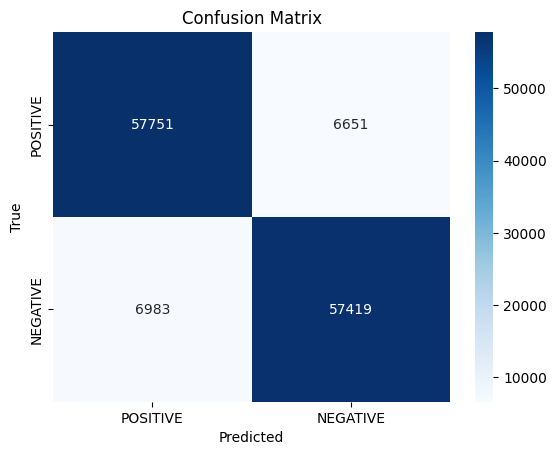

Accuracy: 0.8941492500232912
Precision: 0.8941597249189224
Recall: 0.8941492500232912


In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

true_labels = data['true_label']
predicted_labels = data['predicted_sentiment']

cm = confusion_matrix(true_labels, predicted_labels, labels=unique_labels)

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted', labels=unique_labels)
recall = recall_score(true_labels, predicted_labels, average='weighted', labels=unique_labels)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")